In [2]:
import pandas as pd
import pandas_profiling
import numpy as np 
import os
import datetime
import sys
import pickle
import math
import matplotlib.pyplot as plt

## Question 1: 
Download the R3K_Daily.bz2 file  Download Download the R3K_Daily.bz2 filethat contains the Panda DataFrames containing these data. The DataFrames are stored in pickle format with bz2 compression. 
## Question 1-A 
What is the advantage of the pickle format? 

Answer: Compression as well as maintaining dimentionality - bz2 includes additional compression. 
Especially important with tensors/arrays > 2d or other python objects that lend themselves to being written to a file. Pickling is typically a best practice when written file isn't required to be human readable because it's faster to access. 
## Question 1-B 
What is an advantage of DataFrames vs. Numpy arrays? (1 pt)

Answer: Many built in methods to slice, perform SQL like operations, and easily manipulate data. However this comes with a downside of higher processing costs, slower indexing, and a limit to only two dimension, which is where Numpy shines. However this speed difference is neglible after about 500,000 rows.



In [3]:
def loosen(file):
 pikd = open(file, 'rb')
 data = pickle.load(pikd)
 pikd.close()
 return data
df = loosen('R3K_Daily')


In [4]:
df = loosen('R3K_Daily')


# Question 2
Give an example of a dual class stock contained in the data. (1 pt)

Answer: see below however, there are some examples where the .A/.B/.C convention is not used (i.e. GOOG vs GOOGL) so without additional data, these can't be teased out of the given dataset

It looks like BF is the only symbol with both the .A and .B suffix however there are others that identify their class. For example Birkshire is known to be a dual class stock but only the B class has the .B suffix. 

In [35]:
df[df['Symbol'].str.contains('\.')].groupby('Symbol').count().Date


Symbol
BF.A      4593
BF.B      4593
BRK.B     4592
CRD.B     4593
FCE.A'    4532
HEI.A     4592
JW.A      4592
LEN.B     3996
MOG.A     4593
Name: Date, dtype: int64

# Question 2
Run the profiling function. 
## Question 2-A
What is the Minimum Close price? 

Answer: Minimum Close price is: 0.00889341 per the report


In [3]:
# Use old pandas profiling to get language requested in question 
# Close is rejected so will need to run profiling on rejected variable
pandas_profiling.ProfileReport(df)


Number of variables,8
Number of observations,3894844
Total Missing (%),0.0%
Total size in memory,237.7 MiB
Average record size in memory,64.0 B
Numeric,3
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,3


In [4]:
# Profiling for rejected variables
# Details>Extreme values is where minimum for Close value is found
rejected = pandas_profiling.ProfileReport(df).get_rejected_variables()
pandas_profiling.ProfileReport(df[rejected])


Number of variables,3
Number of observations,3894844
Total Missing (%),0.0%
Total size in memory,89.1 MiB
Average record size in memory,24.0 B
Numeric,1
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,2


## Question 2-B
Which stock does that belong to? 

Answer: WETF

In [45]:
df.Symbol[df['Close']==df['Close'].min()]

3707037    WETF
Name: Symbol, dtype: object

# Question 3
Is it really possible to trade a stock that is worth less than a cent? If not, what is the cause of such low prices? (1 pt)

Answer: Yes; pink sheets also known as penny stocks. Generally these are high risk very low cap issues that have additional predatory risks on the issuer side. 


# Question 4
What does “Rejected” mean next to the line “High is highly correlated with Close”? (1 pt)

Answer: The variable is rejected because it's highly correlated with another variable. Multicolinarity is an issue in linear and logistic regression, however tree methods and nerual networks are robust to multicolinarilty.  


# Question 5
Compare the price histories of KORS vs CPRI: do you notice anything strange? Read Michael Kors Holdings Limited to be renamed Capri Holdings Limited.  (Links to an external site.) Capri. (2018, September 25) and explain how you would handle these price histories. (1 pt)

Answer: the close is unadjusted for both issues as seen below and is in lockstep from 2011 to 2018 until about the last 30 days of trade for KORS. Excluding the last ~30 days of trade, RMSE is 0. Including all data from 2011 to when KORS stopped trading, total RMSE increases to 0.1094

I would use the KORS ticker and until December 31, 2018 then begin to use CPRI the adjust for analysis to prevent data leakage. The slight variance could be a data issue and not worth the hastle of imputing, averaging, etc for a small fraction of the time series. Another approach could be to put this time period in an embargo and ignore it.  Also curious about a potential data issue since the price towards the end is an exact lag versus arbitrage between the symbols prior to the transition to the new ticker.

In [ ]:
# Helper Functions:

# Calculate root mean squared error
def rmse(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        prediction_error = predicted[i] - actual[i]
        sum_error += (prediction_error ** 2)
        mean_error = sum_error / float(len(actual))
    return math.sqrt(mean_error)

def plot_comparison(symbol_A, symbol_B, column, begin_date=None, end_date=None):
    df_symbol_A=df[df.Symbol==symbol_A].reset_index(drop=True, inplace=False)
    df_symbol_B=df[df.Symbol==symbol_B].reset_index(drop=True, inplace=False)
    
    if begin_date:
        df_symbol_A = df_symbol_A[column][df_symbol_A.Date > begin_date]
        df_symbol_B = df_symbol_B[column][df_symbol_B.Date > begin_date] 
        title = f'Beginning {begin_date.date()}'
    elif end_date:
        df_symbol_A = df_symbol_A[column][df_symbol_A.Date < end_date]
        df_symbol_B = df_symbol_B[column][df_symbol_B.Date < end_date] 
        title = f'Ending {end_date.date()}'        
    elif end_date and end_date:
        df_symbol_A = df_symbol_A[column].between(begin_date, end_date, inclusive = True)
        df_symbol_B = df_symbol_B[column].between(begin_date, end_date, inclusive = True)    
        title = f'Between {begin_date.date()} and {end_date.date()}'        
    else:
        df_symbol_A = df_symbol_A[column]
        df_symbol_B = df_symbol_B[column]
        title = 'All Time'
                
    df_symbol_A.reset_index(drop=True, inplace=True)
    df_symbol_B.reset_index(drop=True, inplace=True)
    
    # To compare only ticks where both symbols exist 
    # Subtracting 1 to convert from count to index to slice df
    shortest_duration = int(np.where(len(df_symbol_A)<len(df_symbol_B),
                                     len(df_symbol_A),
                                     len(df_symbol_B))
                           )-1
    rmse_value = rmse(df_symbol_A[:shortest_duration], df_symbol_B[:shortest_duration])
    plt.plot(df_symbol_A[:shortest_duration], 
             color='red', 
             linewidth=2, 
             label=symbol_A)
    plt.plot(df_symbol_B[:shortest_duration], 
             color='blue', 
             linewidth=1, 
             label=symbol_B)
    plt.title(f'{column} Price {title} \nRMSE: {round(rmse_value,4)}')
    plt.ylabel('Price in Dollars')
    plt.xlabel('Days')
    plt.legend()
    plt.show()
    

In [127]:
# beginning date for each issue
minimum_date = df.groupby('Symbol', as_index=False)['Date'].min()
minimum_date[minimum_date.Symbol.isin(['KORS','CPRI'])]


,Symbol,Date
228,CPRI,2011-12-15
533,KORS,2011-12-15


In [129]:
# last date for each issue
max_date = df.groupby('Symbol', as_index=False)['Date'].max()
max_date[max_date.Symbol.isin(['KORS','CPRI'])]


,Symbol,Date
228,CPRI,2019-03-08
533,KORS,2018-12-31


In [138]:
# confirm end of data for all issues in dataset
df.Date.max()


Timestamp('2019-03-08 00:00:00')

In [135]:
# Confirming price changes for KORS until EOY 2018
# Appears active trades until EOY
df[df.Symbol=='KORS'].tail(10)


,Date,Open,High,Low,Close,UnAdjustedClose,Volume,Symbol
1985329,2018-12-17,37.47,39.13,36.97,38.10,38.10,52809,KORS
1985330,2018-12-18,38.36,38.89,37.71,37.98,37.98,40470,KORS
1985331,2018-12-19,38.11,38.77,37.58,37.92,37.92,43431,KORS
1985332,2018-12-20,37.62,38.23,36.88,37.09,37.09,29311,KORS
1985333,2018-12-21,37.44,38.12,36.39,36.41,36.41,45460,KORS
1985334,2018-12-24,36.70,36.92,35.68,36.03,36.03,12770,KORS
1985335,2018-12-26,36.21,37.83,35.93,37.76,37.76,34116,KORS
1985336,2018-12-27,37.30,37.93,36.51,37.87,37.87,28124,KORS
1985337,2018-12-28,37.96,38.12,37.01,37.18,37.18,21163,KORS
1985338,2018-12-31,37.32,37.93,37.03,37.92,37.92,21298,KORS


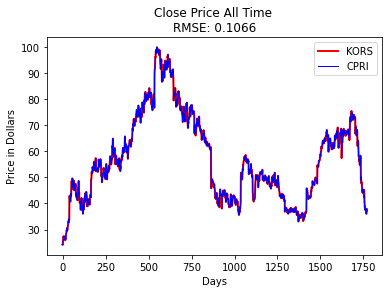

In [256]:
plot_comparison('KORS','CPRI','Close')


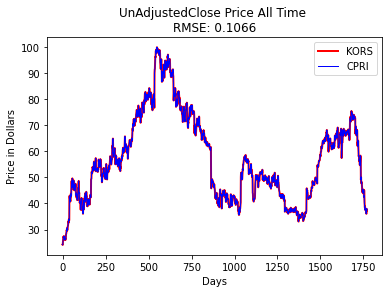

In [257]:
plot_comparison('KORS','CPRI','UnAdjustedClose')


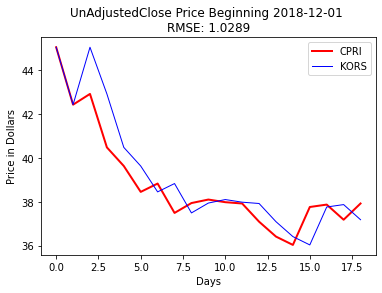

In [258]:
plot_comparison('CPRI','KORS','UnAdjustedClose', begin_date=pd.Timestamp('2018-12-01'))


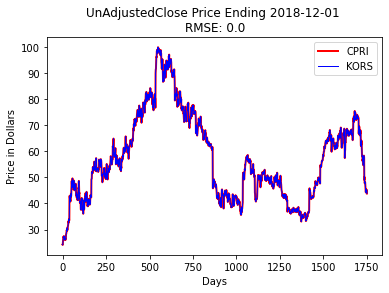

In [251]:
plot_comparison('CPRI','KORS','UnAdjustedClose', end_date=pd.Timestamp('2018-12-01'))


# Question 6
Compare the price histories of GOOG vs GOOGL. Do you notice anything strange? Read Alphabet, Inc (Links to an external site.). Wikipedia and explain how you would handle these price histories. (1 pt)

parent company of Google and several former Google subsidiaries.[3][4][5] The two co-founders of Google remained as controlling shareholders, board members, and employees at Alphabet

announced: August 10, 2015 
completed: October 2, 2015

Alphabet retains Google Inc.'s stock price history and continues to trade under Google Inc.'s former ticker symbols "GOOG" and "GOOGL"

Alphabet is mostly a collection of companies. The largest of which, of course, is Google. This newer Google is a bit slimmed down, with the companies that are pretty far afield of our main internet products contained in Alphabet instead

Answer: Depending on trading strategy, I would consider keeping both. Especially for a buy and hold since Alphabet represents many more forward looking projects like drone delivery. Shorter term strategies may not make sense unless a closer examination showed alpha for pair trading or other arb strategies.  




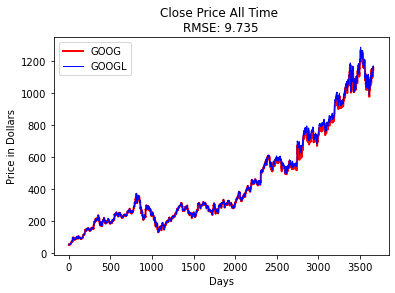

In [259]:
plot_comparison('GOOG','GOOGL','Close')


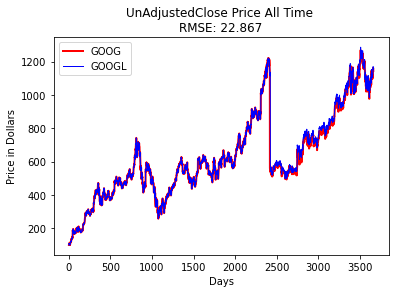

In [265]:
plot_comparison('GOOG','GOOGL','UnAdjustedClose')


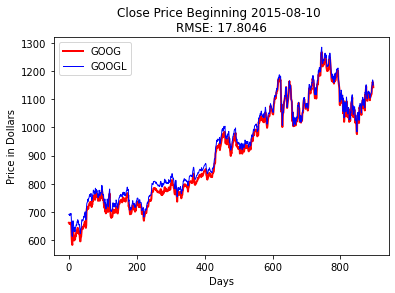

In [262]:
# From announcemnt to transition  
plot_comparison('GOOG',
                'GOOGL',
                'Close',
                begin_date=pd.Timestamp('2015-08-10'), 
                end_date=pd.Timestamp('2015-10-02'))

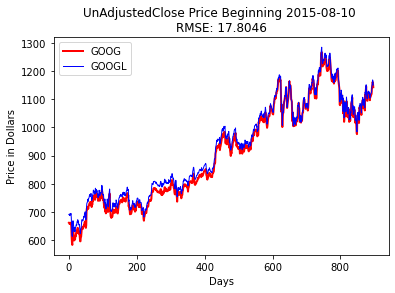

In [266]:
# From announcemnt to transition  
plot_comparison('GOOG',
                'GOOGL',
                'UnAdjustedClose',
                begin_date=pd.Timestamp('2015-08-10'), 
                end_date=pd.Timestamp('2015-10-02'))

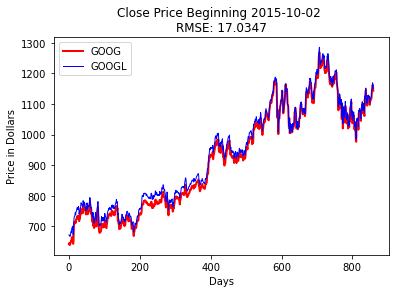

In [263]:
# After transition 
plot_comparison('GOOG',
                'GOOGL',
                'Close',
                begin_date=pd.Timestamp('2015-10-02'))

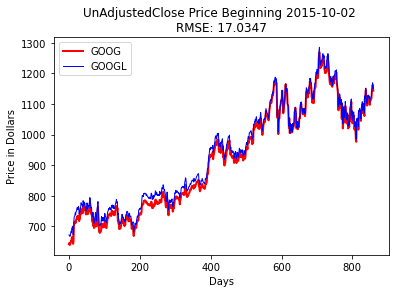

In [267]:
# After transition 
plot_comparison('GOOG',
                'GOOGL',
                'UnAdjustedClose',
                begin_date=pd.Timestamp('2015-10-02'))

# Question 7
Compare the price histories of GOV vs OPI: do you notice anything odd? Read NA.  Government Properties Income Trust Announces the Completion of its Merger with Select Income REIT. (Links to an external site.)  Business Wire. (2018, December 31)   and spell out how you would handle these price histories. (1 pt)


New ticker OPI 1-for-4 reverse split of GOV on January 2, 2019

Answer: I would use GOV until January 2, 2019, then transition to using the adjusted close for OPI, which in our dataset is simply "Close." This prevents data leakage in a real-time process. If doing a simple historical analysis, it may make since to ignore GOV and only review the history for OPI.   



In [28]:
# beginning date for each issue
min_date = df.groupby('Symbol', as_index=False)['Date'].min()
min_date = min_date[min_date.Symbol.isin(['GOV','OPI'])]
min_date.reset_index(inplace=True, drop=True)

# last date for each issue
max_date = df.groupby('Symbol', as_index=False)['Date'].max()
max_date = max_date[max_date.Symbol.isin(['GOV','OPI'])]
max_date.reset_index(inplace=True, drop=True)


min_max_dates=pd.concat([min_date,max_date.Date], axis=1)
min_max_dates.columns =['Symbol', 'Begin Trade', 'End Trade']
print(f'Min date in data: {df.Date.min()}, \nMax date in data: {df.Date.max()}')

min_max_dates


Min date in data: 2000-12-01 00:00:00, 
Max date in data: 2019-03-08 00:00:00


,Symbol,Begin Trade,End Trade
0,GOV,2009-06-04,2018-12-31
1,OPI,2009-06-04,2019-03-08


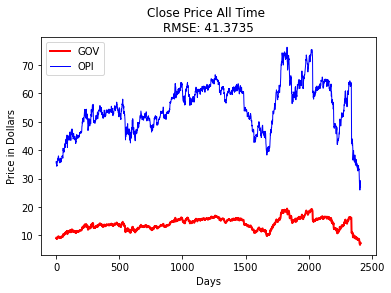

In [268]:
# Close plot
plot_comparison('GOV','OPI','Close')

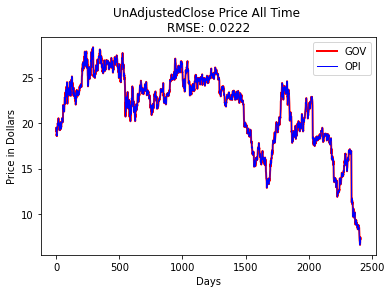

In [269]:
# UnAdjustedClose plot
plot_comparison('GOV','OPI','UnAdjustedClose')

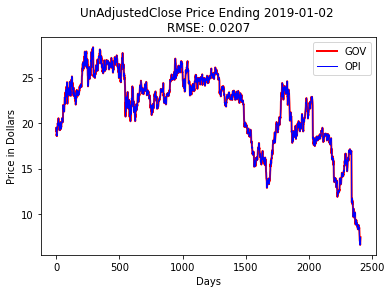

In [271]:
plot_comparison('GOV',
                'OPI',
                'UnAdjustedClose',
                end_date=pd.Timestamp('2019-01-02'))

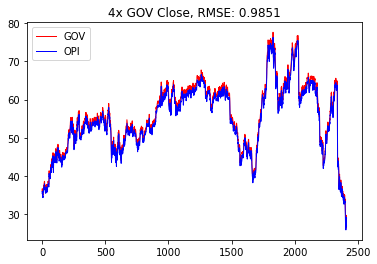

In [97]:
# 4x GOV Close plot
GOV=df.Close[df.Symbol=='GOV'].reset_index(drop=True, inplace=False)*4
OPI=df.Close[df.Symbol=='OPI'].reset_index(drop=True, inplace=False)

shortest_duration = int(np.where(len(GOV)<len(OPI),len(GOV),len(OPI)))-1
close_rmse = rmse(GOV[:shortest_duration],OPI[:shortest_duration])
plt.plot(GOV[:shortest_duration], color='red', linewidth=1, label='GOV')
plt.plot(OPI[:shortest_duration], color='blue', linewidth=1, label='OPI' )
plt.title(f'4x GOV Close, RMSE: {round(close_rmse,4)}')
plt.legend()
plt.show()

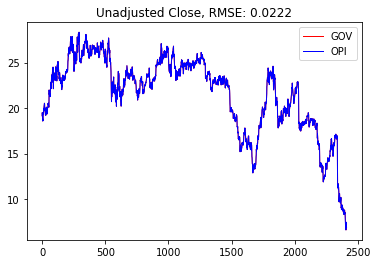

In [99]:
# Unadjusted Close
unadj_GOV=df.UnAdjustedClose[df.Symbol=='GOV'].reset_index(drop=True, inplace=False)
unadj_OPI=df.UnAdjustedClose[df.Symbol=='OPI'].reset_index(drop=True, inplace=False)

shortest_duration = int(np.where(len(unadj_GOV)<len(unadj_OPI),len(unadj_GOV),len(unadj_OPI)))-1
unadj_close_rmse = rmse(unadj_GOV[:shortest_duration],unadj_OPI[:shortest_duration])
plt.plot(unadj_GOV[:shortest_duration], color='red', linewidth=1, label='GOV')
plt.plot(unadj_OPI[:shortest_duration], color='blue', linewidth=1, label='OPI' )
plt.title(f'Unadjusted Close, RMSE: {round(unadj_close_rmse,4)}')
plt.legend()
plt.show()

# Question 8
When you have a company that issues two classes of stocks (e.g. BF.A and BF.B), should you include both classes in your data? Discuss when it is a good idea to include them both and when you should not. (1 pt)

Answer: If dividends are important to your stategy, usually class A shares are given higher dividend priority and additional voting rights. Class A shares tend to have lower volume which reduces liquidity and increases volitility. I think that there's a case for all permuations to be considered (A, B, and both) depending on the desired strategy and risk profile. 


https://www.sofi.com/learn/content/classes-of-stock-shares/
https://seekingalpha.com/article/3970046-what-to-choose-bombardiers-class-b-shares

# Question 9
What is “survivorship bias” with respect to a stock database? If I claim that this dataset represents US stocks with the top 1,000 market capitalization, does it have survivorship bias? Devise a simple method to find out. (2 pt)

Answer: Check a few companies you know went bankrupt and confirm they are in the dataset. If they are not, survivorship bias exists in the dataset.

